# データ作成

In [3]:
import numpy as np
import pandas as pd

データファイルの作成のためには，以下で説明するGDPと失業率のファイルをこのJupyter Notebookと同じフォルダーに置くことを前提とする。

## GDP

* 実額・四半期・実質季節調整系列（CSV形式：34KB）
    * ファイル名：gaku-jk2012.csv
    * [リンク](https://www.esri.cao.go.jp/jp/sna/data/data_list/sokuhou/files/2020/qe201_2/gdemenuja.html)
    
読み込む列を指定する。

In [4]:
df_gdp = pd.read_csv('./gaku-jk2012.csv',encoding='cp932').iloc[6:-2,[0,1]]
df_gdp.head()
# df1994_2020.tail()

,実質季節調整系列,Unnamed: 1
6,1994/ 1- 3.,"425,124.3"
7,4- 6.,"423,053.3"
8,7- 9.,"427,848.1"
9,10-12.,"426,084.1"
10,1995/ 1- 3.,"430,980.6"


列名変更

In [5]:
df_gdp.columns = ['year','gdp']
df_gdp.head(2)

,year,gdp
6,1994/ 1- 3.,"425,124.3"
7,4- 6.,"423,053.3"


* インデックの変更
* 列`year`を削除

In [6]:
idx = pd.Series(pd.date_range('1994', freq='Q', periods=len(df_gdp)))
df_gdp = df_gdp.set_index(idx).drop('year',axis=1)
df_gdp.columns

Index(['gdp'], dtype='object')

* 数字の`,`を削除
* `float`に変換

In [7]:
df_gdp['gdp'] = df_gdp['gdp'].str.replace(',','').astype(float)

図示

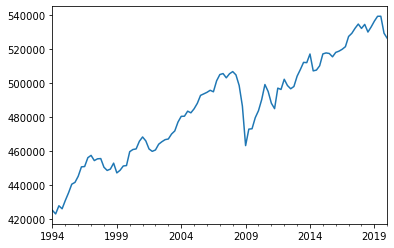

In [8]:
_ = df_gdp['gdp'].plot()

## 失業率

* 景気動向指数（速報、改訂値）（月次） 結果
    * 系列 （令和2(2020)年8月7日）個別系列の数値
    * 遅行系列(Excel形式：53KB)
    * 0807ci3.xlsx
    * [リンク](https://www.esri.cao.go.jp/jp/stat/di/di.html)
    
読み込む行列を指定する。

In [9]:
df_u = pd.read_excel('./0807ci3.xlsx').iloc[232:547,[1,2,8]]
df_u.head()
# df_u.tail()

,Unnamed: 1,Unnamed: 2,Lg6
232,1994,1,2.76
233,1994,2,2.89
234,1994,3,2.9
235,1994,4,2.84
236,1994,5,2.79


列ラベルを変更

In [10]:
df_u.columns =['year','month','unemployment_rate']
df_u.head()

,year,month,unemployment_rate
232,1994,1,2.76
233,1994,2,2.89
234,1994,3,2.9
235,1994,4,2.84
236,1994,5,2.79


* インデックの変更
* 列`year`と`month`を削除

In [11]:
start = df_u.iloc[0,0]
start

1994

In [12]:
idx_u = pd.Series(pd.date_range(str(start), freq='M', periods=len(df_u)))
df_u = df_u.set_index(idx_u).drop(['year','month'],axis=1)
df_u.columns

Index(['unemployment_rate'], dtype='object')

* `float`に変換

In [13]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].astype(float)

* 四半期の平均を計算
* 四半期最後の月に結果を挿入

In [14]:
df_u['unemployment_rate'] = df_u['unemployment_rate'].resample('Q',label='right').mean()

* 他の月を削除

In [15]:
df_u = df_u.dropna()

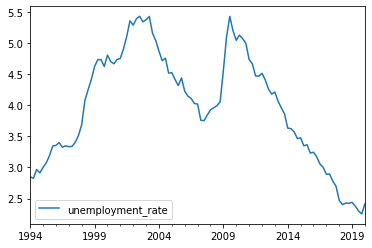

In [16]:
_ = df_u.plot()

## データの結合

* `df_gdp`と`df_u`の結合

In [17]:
df = pd.merge(left=df_gdp, right=df_u,
              left_index=True, right_index=True, how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1994-03-31 to 2020-03-31
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gdp                105 non-null    float64
 1   unemployment_rate  105 non-null    float64
dtypes: float64(2)
memory usage: 7.5 KB


## 成長率と失業率の変化

* GDP成長率の計算
    * GDPのデータは季節調整済みであり、年換算での算出を意味している。
    * このデータを使って前期比の成長率を計算すると，毎四半期の成長率となる。これを$g_{\text{四半期}}$とすると，年率換算するためには次のようになる。
    
    $$
    1+g_{\text{年}}=(1+g_{\text{四半期}})^4
    $$
    
次のコードは前期比で計算しているため、毎四半期の成長率である。

In [18]:
df['gdp_growth'] = 100*df['gdp'].pct_change()

* 失業率の乖離の計算

In [19]:
df['u_change'] = df['unemployment_rate'].diff()

## ファイルの保存

In [20]:
df.head()

,gdp,unemployment_rate,gdp_growth,u_change
1994-03-31,425124.3,2.850000,NaN,NaN
1994-06-30,423053.3,2.823333,-0.487152,-0.026667
1994-09-30,427848.1,2.966667,1.133380,0.143333
1994-12-31,426084.1,2.913333,-0.412296,-0.053333
1995-03-31,430980.6,3.000000,1.149186,0.086667


* `gdp_growth`と`u_deviation`以外の列を削除

In [21]:
df = df[['gdp_growth','u_change']]
df.head()

,gdp_growth,u_change
1994-03-31,NaN,NaN
1994-06-30,-0.487152,-0.026667
1994-09-30,1.133380,0.143333
1994-12-31,-0.412296,-0.053333
1995-03-31,1.149186,0.086667


* このJupyter Notebookがあるフォルダーに`gakushu2021.csv`として保存する

In [22]:
df.reset_index().to_csv('gakushu2021.csv',index=False)

# 「Pythonのすすめ」のコード

## データの読み込み

In [23]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

url = 'https://bit.ly/2XSaUwK'
df = pd.read_csv(url,index_col='index',parse_dates=True)

In [24]:
df.head()

,gdp_growth,u_change
index,,
1994-03-31,NaN,NaN
1994-06-30,-0.487152,-0.026667
1994-09-30,1.133380,0.143333
1994-12-31,-0.412296,-0.053333
1995-03-31,1.149186,0.086667


## 図示と簡単な計算

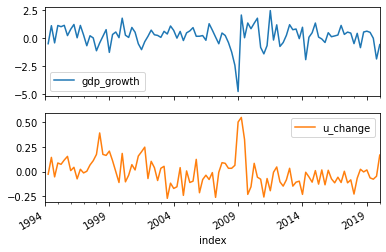

In [25]:
df.plot(subplots=True);

In [26]:
df.mean()

gdp_growth    0.210336
u_change     -0.004135
dtype: float64

In [27]:
df.std()

gdp_growth    0.961647
u_change      0.145540
dtype: float64

In [28]:
df.corr()

,gdp_growth,u_change
gdp_growth,1.00000,-0.17249
u_change,-0.17249,1.00000


In [29]:
df['gdp_growth'].autocorr()

0.12853268468043708

In [30]:
df['u_change'].autocorr()

0.43469211721004114

## 最小二乗法による推定

In [31]:
formula = 'gdp_growth ~ u_change'

In [32]:
model = ols(formula, data=df)

In [33]:
result = model.fit()

In [34]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.128
Date:                Sun, 04 Oct 2020   Prob (F-statistic):             0.0800
Time:                        09:14:05   Log-Likelihood:                -141.43
No. Observations:                 104   AIC:                             286.9
Df Residuals:                     102   BIC:                             292.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2056      0.093      2.202      0.0

In [35]:
(1+0.01*result.params[0])**4-1

0.008250344413233579

In [36]:
growth_quarter = result.params[0]+result.params[1]

In [37]:
(1+0.01*growth_quarter)**4-1

-0.036843400364254486